In [57]:
import pandas as pd
from sqlalchemy import create_engine
import json

# 접속 정보 로딩 (옵션: db-config.json 파일이 있을 경우)
with open('db-config.json') as f:
    config = json.load(f)

user = config['user']
password = config['password']
host = config['host']
port = config['port']
database = config['database']

# SQLAlchemy 엔진 생성
engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:{port}/{database}?charset=utf8mb4")

# vehicle_reg_stats 테이블 데이터 읽어오기
query4 = "SELECT * FROM vehicle_reg_stats"
vehicle = pd.read_sql(query4, con=engine)

# ▶ 결과 확인
vehicle.head()

,id,datetime,region,fuel_type,use_type,reg_count
0,1,2017-01-01,강원,경유,사업용,12362.0
1,2,2017-01-01,광주,전기,비사업용,240.0
2,3,2017-01-01,인천,전기,사업용,6.0
3,4,2017-01-01,인천,전기,비사업용,210.0
4,5,2017-01-01,대구,전기,사업용,53.0


In [59]:

# air_pollution 테이블 데이터 읽어오기
query = "SELECT * FROM air_pollution"
pollution = pd.read_sql(query, con=engine)

# datetime 컬럼을 datetime 타입으로 변환
pollution['datetime'] = pd.to_datetime(pollution['datetime'])

In [60]:
# air_quality 테이블 데이터 읽어오기
query = "SELECT * FROM air_quality"
quality = pd.read_sql(query, con=engine)

# datetime 컬럼을 datetime 타입으로 변환
quality['datetime'] = pd.to_datetime(quality['datetime'])

In [61]:
# 1. 두 시리즈 준비 (월별 기준, 2021-12 이후)
diesel_series = diesel_monthly[diesel_monthly['datetime'] >= '2021-12-01'][['datetime', 'reg_count']].rename(columns={'reg_count': 'diesel_business'})
ev_series = ev_monthly[ev_monthly['datetime'] >= '2021-12-01'][['datetime', 'reg_count']].rename(columns={'reg_count': 'ev_total'})

# 2. 날짜 기준 병합
corr_df = pd.merge(diesel_series, ev_series, on='datetime', how='inner')

# 3. 상관계수 계산
correlation = corr_df['diesel_business']

In [63]:
# pollution 처리
pollution = pollution.drop(columns=['id'], errors='ignore')
pollution['datetime'] = pd.to_datetime(pollution['datetime'])
pollution_numeric_cols = pollution.select_dtypes(include='number').columns
monthly_pollution = pollution.groupby(pd.Grouper(key='datetime', freq='M'))[pollution_numeric_cols].mean()

# quality 처리
quality = quality.drop(columns=['id'], errors='ignore')
quality['datetime'] = pd.to_datetime(quality['datetime'])
quality_numeric_cols = quality.select_dtypes(include='number').columns
monthly_quality = quality.groupby(pd.Grouper(key='datetime', freq='M'))[quality_numeric_cols].mean()

C:\Users\USER\AppData\Local\Temp\ipykernel_9984\3396004396.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_pollution = pollution.groupby(pd.Grouper(key='datetime', freq='M'))[pollution_numeric_cols].mean()
C:\Users\USER\AppData\Local\Temp\ipykernel_9984\3396004396.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_quality = quality.groupby(pd.Grouper(key='datetime', freq='M'))[quality_numeric_cols].mean()


In [64]:
monthly_pollution = pollution.groupby(pd.Grouper(key='datetime', freq='M')).mean(numeric_only=True)
monthly_quality = quality.groupby(pd.Grouper(key='datetime', freq='M')).mean(numeric_only=True)

C:\Users\USER\AppData\Local\Temp\ipykernel_9984\1572642877.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_pollution = pollution.groupby(pd.Grouper(key='datetime', freq='M')).mean(numeric_only=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_9984\1572642877.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_quality = quality.groupby(pd.Grouper(key='datetime', freq='M')).mean(numeric_only=True)


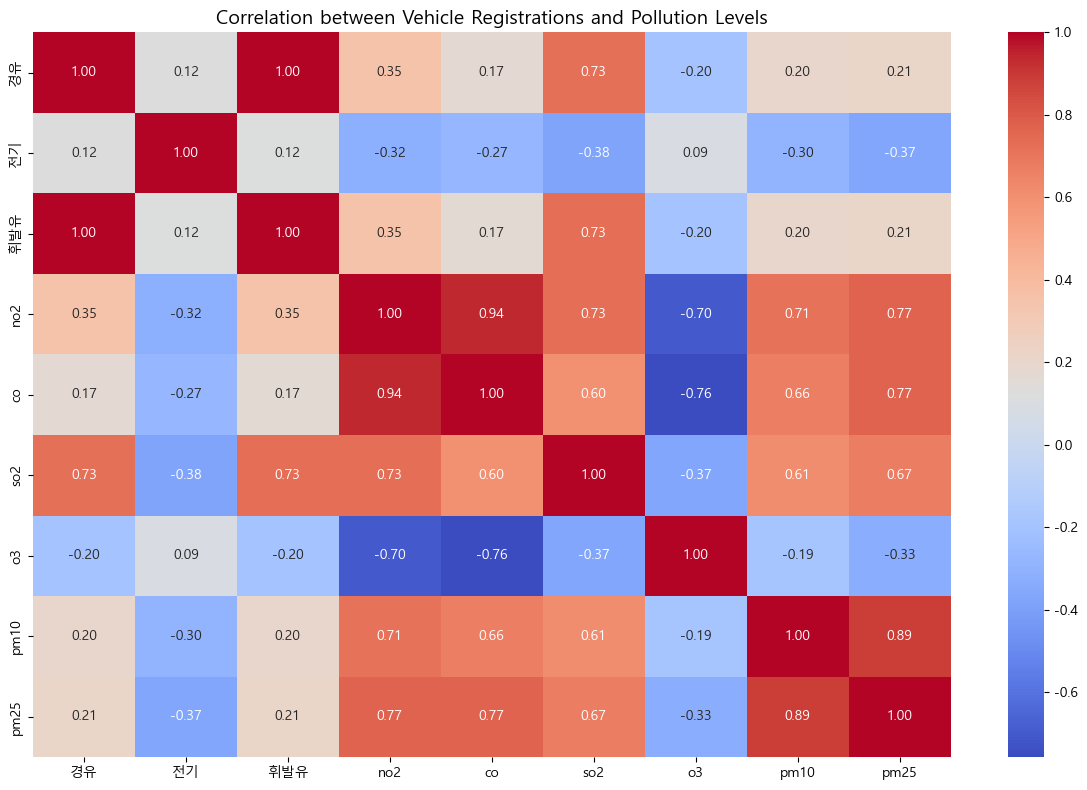

In [67]:
# 1차 병합: monthly_fuel + monthly_pollution
merged1 = pd.merge(
    monthly_fuel, monthly_pollution,
    left_index=True, right_index=True, how='inner'
)

# 2차 병합: merged1 + monthly_quality
merged = pd.merge(
    merged1, monthly_quality,
    left_index=True, right_index=True, how='inner'
)

correlation_matrix = merged.corr()

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation between Vehicle Registrations and Pollution Levels', fontsize=14)
plt.tight_layout()
plt.show()

In [49]:
quality.columns

Index(['id', 'datetime', 'region', 'pm10', 'pm25'], dtype='object')

In [50]:
pollution.columns

Index(['id', 'datetime', 'region', 'no2', 'co', 'so2', 'o3'], dtype='object')